<a href="https://colab.research.google.com/github/Orikson/MAT-421/blob/main/MAT421_Module_B_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Similar to [Module B Part 1](https://github.com/Orikson/MAT-421/blob/a7dc0b733463553f7a4270f71b24cee9fbc0af3c/MAT421_Module_B_pt1.ipynb), what does it look like if we apply the following interpolation methods to vector functions instead of just scalar functions?

Throughout this notebook, different interpolation techniques will be applied for both a 1D ($\hat f:\mathbb{R} \rightarrow \mathbb{R}$) and 2D ($\hat f:\mathbb{R} \rightarrow \mathbb{R}^2$) set of dependent values.

The first function is scalar $y$ as a function of $x$. The second function is vector $[x, y]$ as a function of $t$.

Feel free to change input data values in the below cell.

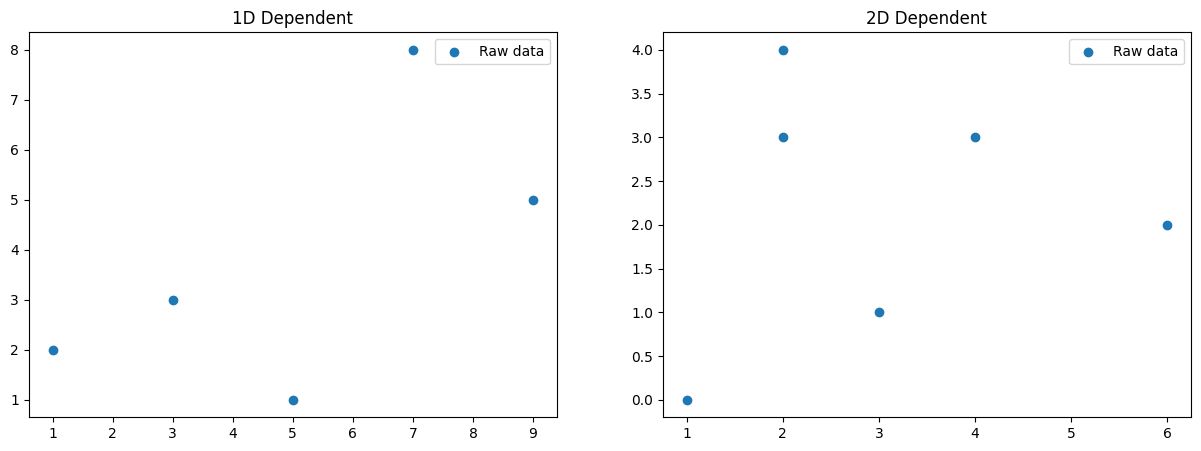

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Raw data
# Note that for consistency, all dependent variables, e.g. y, satisfy len(y.shape) == 2
x = np.array([1, 3, 5, 7, 9])
y = np.array([2, 3, 1, 8, 5])[:,None] # has shape (5,1)

t = np.array([0, 2, 4, 6, 8, 10])
r = np.transpose(np.array([[1, 3, 4, 2, 2, 6],    # has shape (6,2)
                           [0, 1, 3, 4, 3, 2]]))

# Points to interpolate at
xp = np.array([2, 4, 6, 8])
tp = np.array([1, 3, 5, 7, 9])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].scatter(x, *np.transpose(y), label="Raw data")
axs[0].legend()
axs[0].set_title('1D Dependent')
axs[1].scatter(*np.transpose(r), label="Raw data")
axs[1].legend()
axs[1].set_title('2D Dependent')

plt.show()

# Lagrange Polynomial Interpolation

What do we do when we want to represent an interpolation as a single polynomial?

We can use what's called Lagrange polynomials, which is a polynomial constructed by the weighted sum of Lagrange basis polynomials, which are polynomials that, for a selected data point, is 0 at all other data points, and 1 at that data point.

$$P_i(x) = \prod_{j=1,j \neq i}^n \frac{x-x_j}{x_i-x_j}$$

where $x_i$ is the $i$th data point's independent value, and $n$ is the total number of data points. Using this basis function, the full Lagrange polynomial interpolation is then

$$L(x) = \sum_{i=1}^n y_i P_i(x)$$

where $y_i$ is the $i$th data point's dependent value.

By construction, because $L(x)$ is the weighted sum of the basis polynomials, and each basis polynomial is an $n-1$ order polynomial, then $L(x)$ is an $n-1$ order polynomial too.

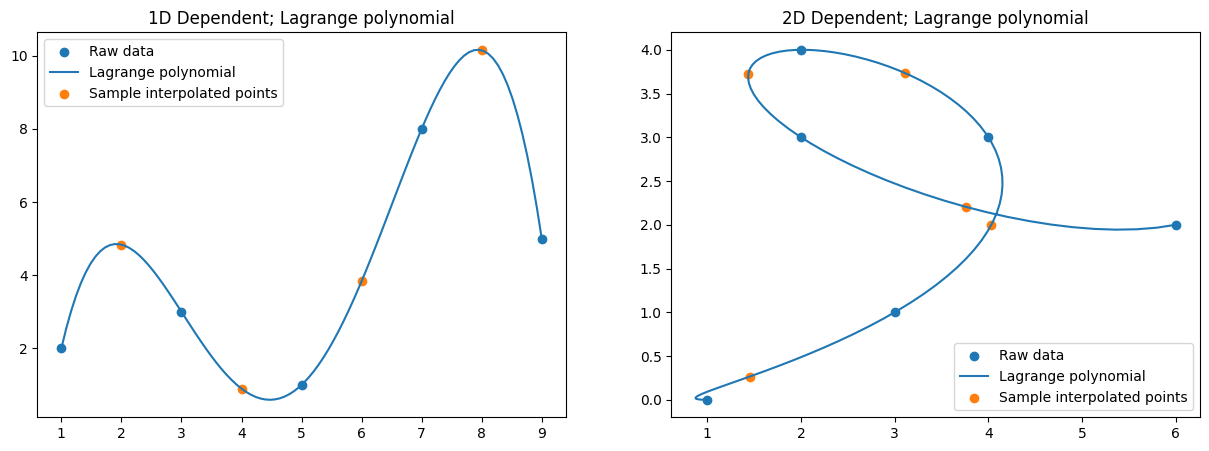

In [4]:
def mask(x, i):
  m = np.full(x.shape, True)
  m[i] = False
  return m

class lagrange_poly:
  def __init__(self, x, y):
    '''
    x - independent variable
    y - dependent variable
    '''
    # sort y with respect to x
    ind = np.argsort(x)
    self.x = x[ind]
    self.y = y[ind]

    self.construct_basis()

  def construct_basis(self):
    '''
    constructs Lagrange polynomial basis functions
    '''
    # helper functions
    chx = lambda x, i: np.repeat(x[:, None], self.x.shape[0]-1, axis=1)
    csx = lambda x, i: np.repeat(self.x[mask(self.x, i)][None, :], x.shape[0], axis=0)
    cdx = lambda x, i: np.repeat(self.x[i], x.shape[0], axis=0)

    chy = lambda x, i: np.repeat(x[:, None], self.y.shape[1], axis=1)
    cdy = lambda x, i: np.repeat(self.y[i][None, :], x.shape[0], axis=0)

    # basis functions and full Lagrange polynomial
    self.Pi = lambda x, i: np.prod(chx(x, i) - csx(x, i), axis=1) / np.prod(chx(cdx(x, i), i) - csx(cdx(x, i), i), axis=1)
    self.yi_Pi = lambda x, i: cdy(x, i) * chy(self.Pi(x, i), i)
    self.L = lambda x: np.sum(np.array([self.yi_Pi(x, i) for i in range(self.x.shape[0])]), axis=0)

  def __call__(self, xp):
    return self.L(xp)

lp_1 = lagrange_poly(x, y)
lp_2 = lagrange_poly(t, r)

yp = lp_1(xp)
rp = lp_2(tp)

lx_plot_1 = np.linspace(np.min(x), np.max(x), num=100)
ly_plot_1 = lp_1(lx_plot_1)
lx_plot_2 = np.linspace(np.min(t), np.max(t), num=100)
ly_plot_2 = lp_2(lx_plot_2)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].scatter(x, *np.transpose(y), label="Raw data")
axs[0].plot(lx_plot_1, ly_plot_1, label="Lagrange polynomial")
axs[0].scatter(xp, yp, label="Sample interpolated points")
axs[0].legend()
axs[0].set_title('1D Dependent; Lagrange polynomial')
axs[1].scatter(*np.transpose(r), label="Raw data")
axs[1].plot(*np.transpose(ly_plot_2), label="Lagrange polynomial")
axs[1].scatter(*np.transpose(rp), label="Sample interpolated points")
axs[1].legend()
axs[1].set_title('2D Dependent; Lagrange polynomial')

plt.show()

# Newton's Polynomial Interpolation

Alternatively, another way to generate an $n-1$ order polynomial is Newton's polynomial interpolation. Newton's polynomial can be written in the form

$$f(x) = \sum_{i=0}^n a_i n_i(x)$$
$$n_i(x) = \prod_{j=0}^{i-1} (x - x_j)$$

where $a_i$ is a coefficient that follows from the iterative divided differences procedure. For a single divided difference we have $f[x_1, x_0] = \frac{y_1 - y_0}{x_1 - x_0}$, and for increasingly higher order differences we have
$$f[x_n, x_{n-1}, ..., x_1, x_0] = \frac{f[x_n, x_{n-1}, ..., x_2, x_1] - f[x_{n-1}, x_{n-2}, ..., x_1, x_0]}{x_n - x_0}$$
Each $a_i$ is defined then as $a_i = f[x_i, x_{i-1}, ..., x_1, x_0]$.

This creates an upper triangular matrix (depending on the way you write it), where we can compute each divided difference iteratively.

It's cool to note that Newton and Lagrange polynomial interpolation both produce the same unique polynomial. One pro of Newton interpolation over Lagrange interpolation is that when adding points to the dataset, we only have to compute one more coefficient, whereas in Lagrange interpolation we have to modify every coefficient.


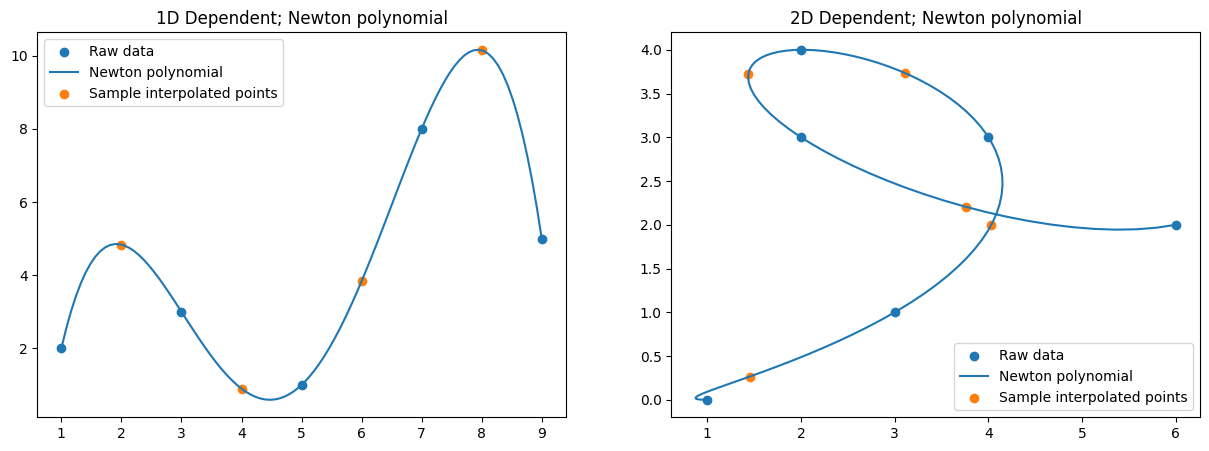

In [5]:
class newton_poly:
  def __init__(self, x, y):
    '''
    x - independent variable
    y - dependent variable
    '''
    # sort y with respect to x
    ind = np.argsort(x)
    self.x = x[ind]
    self.y = y[ind]

    self.compute_coefficients()

  def compute_coefficients(self):
    '''
    computes Newton polynomial coefficients
    '''
    n = len(self.x)
    d = self.y.shape[1]

    coef = np.zeros((d, n, n))
    coef[:,:,0] = np.transpose(self.y)

    for k in range(d):
      for j in range(1,n):
        for i in range(n-j):
          coef[k,i,j] = (coef[k,i+1,j-1] - coef[k,i,j-1]) / (self.x[i+j] - self.x[i])

    self.coef = coef[:,0]

  def __call__(self, xp):
    d = self.y.shape[1]
    n = len(self.x) - 1
    p = [self.coef[i,n] for i in range(d)]
    for k in range(1,n+1):
      for i in range(d):
        p[i] = self.coef[i,n-k] + (xp - self.x[n-k])*p[i]
    return np.transpose(np.array(p))

np_1 = newton_poly(x, y)
np_2 = newton_poly(t, r)

yp = np_1(xp)
rp = np_2(tp)

nx_plot_1 = np.linspace(np.min(x), np.max(x), num=100)
ny_plot_1 = np_1(nx_plot_1)
nx_plot_2 = np.linspace(np.min(t), np.max(t), num=100)
ny_plot_2 = np_2(nx_plot_2)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].scatter(x, *np.transpose(y), label="Raw data")
axs[0].plot(nx_plot_1, *np.transpose(ny_plot_1), label="Newton polynomial")
axs[0].scatter(xp, *np.transpose(yp), label="Sample interpolated points")
axs[0].legend()
axs[0].set_title('1D Dependent; Newton polynomial')
axs[1].scatter(*np.transpose(r), label="Raw data")
axs[1].plot(*np.transpose(ny_plot_2), label="Newton polynomial")
axs[1].scatter(*np.transpose(rp), label="Sample interpolated points")
axs[1].legend()
axs[1].set_title('2D Dependent; Newton polynomial')

plt.show()